In [294]:
#Imports
from math import log, sqrt, pi, exp
from scipy.stats import norm
import pandas as pd
import tensorflow as tf
import numpy as np

def read_file(file):
    """Read a single file and return a dataframe"""
    return pd.read_csv(file, skipinitialspace=True)

In [295]:
# Black-Scholes formula for call options
def d1(S,K,T,r,sigma):
    x1 = S.apply(lambda x : log(x)) - K.apply(lambda x : log(x))
    x2 = (r + ((sigma.apply(lambda x : x**2)) / 2)) * T
    x3 = sigma * T.apply(lambda x: sqrt(x))
    return  (x1 + x2) / x3

def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma) - sigma * T.apply(lambda x : sqrt(x))  

def bs_call(S,K,T,r,sigma):
    T = T/365
    r = r/100
    return S * d1(S,K,T,r,sigma).apply(lambda x : norm.cdf(x)) - K * (-r*T).apply(lambda x : exp(x)) * d2(S,K,T,r,sigma).apply(lambda x : norm.cdf(x))

In [296]:
#Insert file with LSTM predictions
df_options = read_file("data/12-08_10-04_LSTM_2021_combined.csv")
#Calculating BS and add column
df_options["B-S"] = bs_call(df_options["Underlying_last"], df_options["Strike"], df_options["Ttl"], df_options["R"], df_options["Volatility"])
#Cleaning
df_options = df_options[["Quote_date", "Underlying_last", "Strike", "Ttl", "Volatility", "R", "Price", "B-S", "Prediction"]]
df_options_LSTM = df_options.rename(columns={"Prediction":"LSTM"})


#MLP
df_options = read_file("data/12-08_12-10_MLP_2021_combined.csv")
df_options_MLP = df_options["MLP Prediction"]
df_options_MLP = df_options.rename(columns={"MLP Prediction":"MLP"})


In [297]:
df_options = pd.concat([df_options_LSTM, df_options_MLP["MLP"]], axis = 1)

In [298]:
df_options_backup = df_options

Creating table

In [299]:
df_low_money = df_options[df_options["Underlying_last"] / df_options["Strike"] < 0.97]
df_low_money.name = "<0.97"
df_mid_money = df_options[(df_options["Underlying_last"] / df_options["Strike"]).between(0.97, 1.03, inclusive=True)]
df_mid_money.name = "0.97-1.03"
df_high_money = df_options[df_options["Underlying_last"] / df_options["Strike"] > 1.03]
df_high_money.name = ">1.03"

/Users/hjalmarvinje/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  This is separate from the ipykernel package so we can avoid doing imports until


In [300]:
#RMSE
df_RMSE = pd.DataFrame(columns=['Moneyness', 'Maturity', 'BS', 'MPL', 'LSTM'])
for dataframex in [df_low_money, df_mid_money, df_high_money]:
    i = 1
    for days in [89,89,89,179,179,454]:
        df_temp = dataframex[(df_options["Ttl"]).between(i, i + days, inclusive=True)]
        bs = sqrt(tf.keras.metrics.mean_squared_error(df_temp["Price"], df_temp["B-S"]))
        mlp = sqrt(tf.keras.metrics.mean_squared_error(df_temp["Price"], df_temp["MLP"]))
        lstm = sqrt(tf.keras.metrics.mean_squared_error(df_temp["Price"], df_temp["LSTM"]))
        df_RMSE.loc[len(df_RMSE.index)] = [dataframex.name, str(i) + "-" + str(i + days), bs, mlp, lstm]
        i = i + days + 1 

with open('2021_results_RMSE.tex', 'w') as tf:
     tf.write(df_RMSE.round(2).to_latex(index=False))


/Users/hjalmarvinje/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  
/Users/hjalmarvinje/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [301]:
import tensorflow as tf
#MAE
df_MAE = pd.DataFrame(columns=['Moneyness', 'Maturity', 'BS', 'MPL', 'LSTM'])
for dataframex in [df_low_money, df_mid_money, df_high_money]:
    i = 1
    for days in [89,89,89,179,179,454]:
        df_temp = dataframex[(df_options["Ttl"]).between(i, i + days, inclusive=True)]
        bs = (tf.keras.metrics.mean_absolute_error(df_temp["Price"], df_temp["B-S"])).numpy()
        mlp = (tf.keras.metrics.mean_absolute_error(df_temp["Price"], df_temp["MLP"])).numpy()
        lstm = (tf.keras.metrics.mean_absolute_error(df_temp["Price"], df_temp["LSTM"])).numpy()
        df_MAE.loc[len(df_MAE.index)] = [dataframex.name, str(i) + "-" + str(i + days), bs, mlp, lstm]
        i = i + days + 1 

with open('2021_results_MAE.tex', 'w') as tf:
     tf.write(df_MAE.round(2).to_latex(index=False))

/Users/hjalmarvinje/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:7: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  import sys
/Users/hjalmarvinje/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [302]:
import tensorflow as tf
#MAPE
df_MAPE = pd.DataFrame(columns=['Moneyness', 'Maturity', 'BS', 'MPL', 'LSTM'])
for dataframex in [df_low_money, df_mid_money, df_high_money]:
    i = 1
    for days in [89,89,89,179,179,454]:
        df_temp = dataframex[(df_options["Ttl"]).between(i, i + days, inclusive=True)]
        bs = (tf.keras.metrics.mean_absolute_percentage_error(df_temp["Price"], df_temp["B-S"])).numpy()
        mlp = (tf.keras.metrics.mean_absolute_percentage_error(df_temp["Price"], df_temp["MLP"])).numpy()
        lstm = (tf.keras.metrics.mean_absolute_percentage_error(df_temp["Price"], df_temp["LSTM"])).numpy()
        df_MAPE.loc[len(df_MAPE.index)] = [dataframex.name, str(i) + "-" + str(i + days), bs, mlp, lstm]
        i = i + days + 1

with open('2021_results_MAPE.tex', 'w') as tf:
     tf.write(df_MAPE.round(2).to_latex(index=False))

/Users/hjalmarvinje/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:7: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  import sys
/Users/hjalmarvinje/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


****Graphing****

In [303]:
import tensorflow as tf
# Adding errors
moneyness = df_options["Underlying_last"] / df_options["Strike"]
mae_MLP = abs(df_options["Price"] - df_options["MLP"])
mae_LSTM = abs(df_options["Price"] - df_options["LSTM"])
mae_BS = abs(df_options["Price"] - df_options["B-S"])

# Gettting ready for plot
df_extras = pd.concat([moneyness, mae_MLP, mae_LSTM, mae_BS], axis = 1)
df_extras.columns = ["Moneyness", "MAE MLP", "MAR LSTM", "MAE BS"]
df_errors = pd.concat([df_options, df_extras], axis = 1)
dfm = df_errors[["Quote_date", "MAE MLP", "MAR LSTM", "MAE BS"]].melt("Quote_date",var_name='cols', value_name='vals')


**Graphing aggrregated by date**

In [304]:
df_options = df_options.rename(columns={"B-S":"BS"})

        Quote_date  Underlying_last  Strike   Ttl  Volatility     R     Price  \
0       2021-01-04          3701.38  1000.0     2    0.185353  0.09  2701.855   
1       2021-01-05          3727.05  1000.0     1    0.184968  0.08  2726.195   
2       2021-01-04          3701.38  1100.0     2    0.185353  0.09  2598.795   
3       2021-01-05          3727.05  1100.0     1    0.184968  0.08  2626.705   
4       2021-01-04          3701.38  1200.0     2    0.185353  0.09  2500.195   
...            ...              ...     ...   ...         ...   ...       ...   
1845477 2021-12-31          4766.39  9000.0  1085    0.136456  0.97   150.000   
1845478 2021-12-28          4787.26  9200.0  1088    0.138268  0.99     8.100   
1845479 2021-12-29          4792.94  9200.0  1087    0.138236  0.99     9.600   
1845480 2021-12-30          4779.28  9200.0  1086    0.137746  0.98     9.600   
1845481 2021-12-31          4766.39  9200.0  1085    0.136456  0.97   150.000   

                  BS       

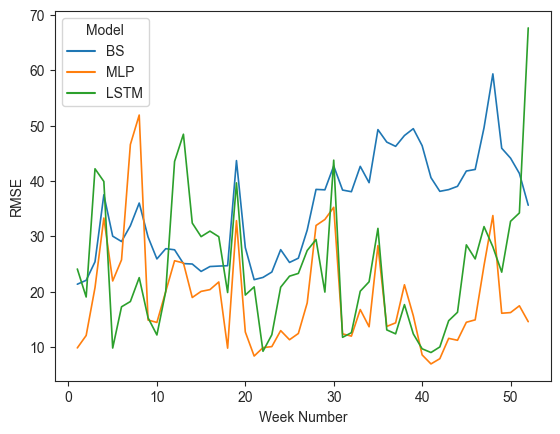

In [305]:
import tensorflow as tf

#Date
df_options_agr = df_options
df_options_agr['Quote_date'] = pd.to_datetime(df_options_agr['Quote_date'])
df_options_agr['Week_number'] = df_options_agr['Quote_date'].dt.isocalendar().week

print(df_options_agr)


rmse_bs = df_options_agr.groupby(df_options_agr.Week_number).apply(lambda x : sqrt(tf.keras.metrics.mean_squared_error(x.Price, x.BS)))
rmse_bs = pd.DataFrame(rmse_bs)
rmse_bs.columns = ["BS"]

rmse_mlp = df_options_agr.groupby(df_options_agr.Week_number).apply(lambda x : sqrt(tf.keras.metrics.mean_squared_error(x.Price, x.MLP)))
rmse_mlp = pd.DataFrame(rmse_mlp)
rmse_mlp.columns = ["MLP"]


rmse_lstm = df_options_agr.groupby(df_options_agr.Week_number).apply(lambda x : sqrt(tf.keras.metrics.mean_squared_error(x.Price, x.LSTM)))
rmse_lstm = pd.DataFrame(rmse_lstm)
rmse_lstm.columns = ["LSTM"]

# Getting dataframe ready
rmse = pd.concat([rmse_bs, rmse_mlp, rmse_lstm], axis = 1)
rmse.reset_index(inplace=True)
rmse_m = rmse.melt("Week_number", var_name='Model', value_name='Errors')

# Plot
from scipy.ndimage.filters import gaussian_filter1d
from scipy import interpolate

sns.set_style("ticks")
sns.lineplot(x="Week_number", y="Errors", hue="Model", linewidth = 1.2,
             data=rmse_m)
plt.xlabel("Week Number")
plt.ylabel("RMSE")
plt.show()

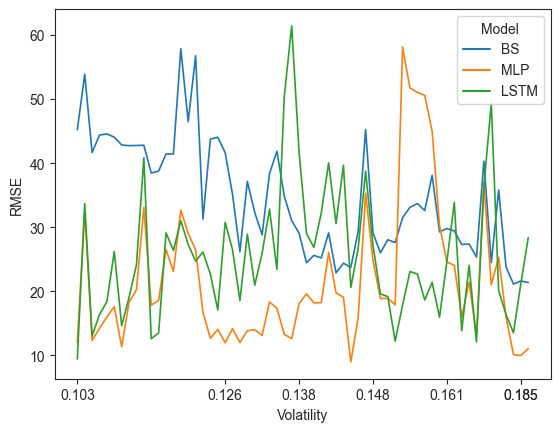

In [306]:
import seaborn as sns
import matplotlib.pyplot as plt

#Volatility
df_options_agr = df_options
df_options_agr["Volatility_six"] = df_options_agr["Volatility"].map(lambda x: str(x)[:5])

rmse_bs = df_options_agr.groupby(df_options_agr.Volatility_six).apply(lambda x : sqrt(tf.keras.metrics.mean_squared_error(x.Price, x.BS)))
rmse_bs = pd.DataFrame(rmse_bs)
rmse_bs.columns = ["BS"]

rmse_mlp = df_options_agr.groupby(df_options_agr.Volatility_six).apply(lambda x : sqrt(tf.keras.metrics.mean_squared_error(x.Price, x.MLP)))
rmse_mlp = pd.DataFrame(rmse_mlp)
rmse_mlp.columns = ["MLP"]


rmse_lstm = df_options_agr.groupby(df_options_agr.Volatility_six).apply(lambda x : sqrt(tf.keras.metrics.mean_squared_error(x.Price, x.LSTM)))
rmse_lstm = pd.DataFrame(rmse_lstm)
rmse_lstm.columns = ["LSTM"]

# Getting dataframe ready
rmse = pd.concat([rmse_bs, rmse_mlp, rmse_lstm], axis = 1)
rmse.reset_index(inplace=True)
rmse_m = rmse.melt("Volatility_six", var_name='Model', value_name='Errors')

#Plot
sns.set_style("ticks")
g = sns.lineplot(x="Volatility_six", y="Errors", hue="Model", linewidth = 1.2,
             data=rmse_m)
sns.set_style("ticks")
plt.xlabel("Volatility")
plt.ylabel("RMSE")
plt.xticks([0,20,30,40,50,60,60])
plt.show()



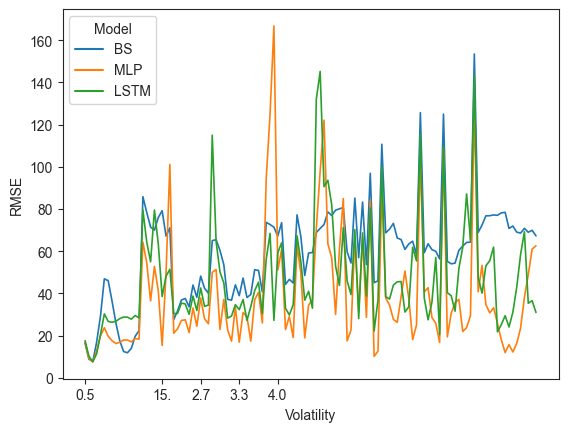

In [307]:
import seaborn as sns
import matplotlib.pyplot as plt

#Moneyness
df_options_agr = df_options
df_options_agr["Moneyness"] = df_options_agr["Underlying_last"] / df_options_agr["Strike"]
df_options_arg = df_options_agr.loc[(df_options_agr["Moneyness"]>=0.5) & (df_options_agr["Moneyness"]<=5)]
df_options_agr["Moneyness_round"] = df_options_agr["Moneyness"].map(lambda x: str(x)[:3])

rmse_bs = df_options_agr.groupby(df_options_agr.Moneyness_round).apply(lambda x : sqrt(tf.keras.metrics.mean_squared_error(x.Price, x.BS)))
rmse_bs = pd.DataFrame(rmse_bs)
rmse_bs.columns = ["BS"]

rmse_mlp = df_options_agr.groupby(df_options_agr.Moneyness_round).apply(lambda x : sqrt(tf.keras.metrics.mean_squared_error(x.Price, x.MLP)))
rmse_mlp = pd.DataFrame(rmse_mlp)
rmse_mlp.columns = ["MLP"]


rmse_lstm = df_options_agr.groupby(df_options_agr.Moneyness_round).apply(lambda x : sqrt(tf.keras.metrics.mean_squared_error(x.Price, x.LSTM)))
rmse_lstm = pd.DataFrame(rmse_lstm)
rmse_lstm.columns = ["LSTM"]

# Getting dataframe ready
rmse = pd.concat([rmse_bs, rmse_mlp, rmse_lstm], axis = 1)
rmse.reset_index(inplace=True)
rmse_m = rmse.melt("Moneyness_round", var_name='Model', value_name='Errors')

#Plot
sns.set_style("ticks")
g = sns.lineplot(x="Moneyness_round", y="Errors", hue="Model", linewidth = 1.2,
             data=rmse_m)
sns.set_style("ticks")
plt.xlabel("Moneyness")
plt.ylabel("RMSE")
plt.xticks([0,20,30,40,50])
plt.show()

        Quote_date  Underlying_last  Strike   Ttl  Volatility     R     Price  \
0       2021-01-04          3701.38  1000.0     2    0.185353  0.09  2701.855   
1       2021-01-05          3727.05  1000.0     1    0.184968  0.08  2726.195   
2       2021-01-04          3701.38  1100.0     2    0.185353  0.09  2598.795   
3       2021-01-05          3727.05  1100.0     1    0.184968  0.08  2626.705   
4       2021-01-04          3701.38  1200.0     2    0.185353  0.09  2500.195   
...            ...              ...     ...   ...         ...   ...       ...   
1845477 2021-12-31          4766.39  9000.0  1085    0.136456  0.97   150.000   
1845478 2021-12-28          4787.26  9200.0  1088    0.138268  0.99     8.100   
1845479 2021-12-29          4792.94  9200.0  1087    0.138236  0.99     9.600   
1845480 2021-12-30          4779.28  9200.0  1086    0.137746  0.98     9.600   
1845481 2021-12-31          4766.39  9200.0  1085    0.136456  0.97   150.000   

                  BS       

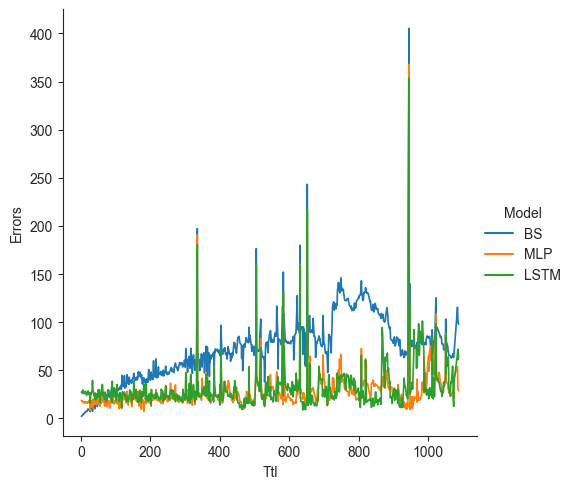

In [308]:
import seaborn as sns

# Time to maturity
df_options_agr = df_options
#df_options_agr["Ttl_round"] = df_options_agr["Ttl"].astype(str).str[:4].astype(np.int64)
print(df_options_agr)

rmse_bs = df_options_agr.groupby(df_options_agr.Ttl).apply(lambda x : sqrt(tf.keras.metrics.mean_squared_error(x.Price, x.BS)))
rmse_bs = pd.DataFrame(rmse_bs)
rmse_bs.columns = ["BS"]

rmse_mlp = df_options_agr.groupby(df_options_agr.Ttl).apply(lambda x : sqrt(tf.keras.metrics.mean_squared_error(x.Price, x.MLP)))
rmse_mlp = pd.DataFrame(rmse_mlp)
rmse_mlp.columns = ["MLP"]


rmse_lstm = df_options_agr.groupby(df_options_agr.Ttl).apply(lambda x : sqrt(tf.keras.metrics.mean_squared_error(x.Price, x.LSTM)))
rmse_lstm = pd.DataFrame(rmse_lstm)
rmse_lstm.columns = ["LSTM"]

# Getting dataframe ready
rmse = pd.concat([rmse_bs, rmse_mlp, rmse_lstm], axis = 1)
rmse.reset_index(inplace=True)
rmse_m = rmse.melt("Ttl", var_name='Model', value_name='Errors')

#Plot
sns.set_style("ticks")
sns.relplot(x="Ttl", y="Errors", hue="Model", kind="line", linewidth = 1.2, data=rmse_m)